Following [this](https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning) post.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
google_train_base = pd.read_csv("./Google_train_data.csv")

In [4]:
google_train_base.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


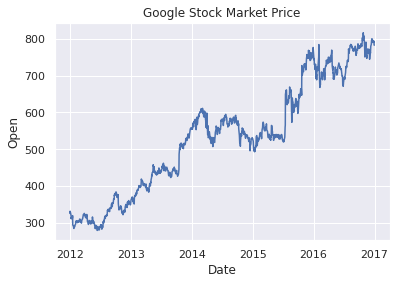

In [5]:
import datetime
import seaborn as sns
sns.set_theme(style="darkgrid")

plot_me_base =  google_train_base.copy()
plot_me_base.Date = plot_me_base.Date.map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
sns.lineplot(x=plot_me_base.Date, y=plot_me_base.Open)
plt.title('Google Stock Market Price')
plt.show()

In [6]:
# We will be using Open Stock to train or model.
training_set = google_train_base.iloc[:, 1:2].values

_Sena's Comment_

Two things about this dataset, obviously the date is not day by day, since we have days that the stock market are closed.

This model ignore those days, thinking it as only an continous line and doesn't cares about date at all.

In [7]:
training_set[:5]

array([[325.25],
       [331.27],
       [329.83],
       [328.34],
       [322.04]])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_training_set[:5]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225]])

_Sena's comment_

Read why is necessary use a Scaler here... Why prices should be scaled?

Because we are using an RNN, since that we need a fast convergency?

In [10]:
# To get regular value for transformed data.
scaler.inverse_transform(scaled_training_set[:5])

array([[325.25],
       [331.27],
       [329.83],
       [328.34],
       [322.04]])

In [12]:
scaled_training_set.shape

(1258, 1)

In [20]:
# Now thats a weird part. We should get X_train and y_train... But isn't this dataset only numbers? Or like a Time Series?
X_train = []
y_train = []
# Magical Numbers... Why?
for i in range(60, 1258):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])